In [90]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [91]:
cotacoes = pd.read_parquet(r'C:\Users\vncsa\Documents\Base de dados\economatica\novos_dados_economatica\parquet\cotacoes.parquet')

acao_escolhida = 'MGLU3'
dados = cotacoes[cotacoes['ticker'] == acao_escolhida].copy()

dados['Date'] = pd.to_datetime(dados['Date']).dt.date

dados = dados[['Date', 'valor']]

dados['cotacao_dia_seguinte'] = dados['valor'].shift(-1)

dados = dados.dropna()

datas = dados['Date']
dados = dados[['valor', 'cotacao_dia_seguinte']]

In [92]:
tamanho_dados_treinamento = int(len(dados) * 0.8)

escalador_treinamento = MinMaxScaler(feature_range=(0, 1))
escalador_teste = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador_treinamento.fit_transform(dados.iloc[0: tamanho_dados_treinamento, :])
dados_entre_0_e_1_teste = escalador_teste.fit_transform(dados.iloc[tamanho_dados_treinamento:, :])

In [93]:
x_treinamento = dados_entre_0_e_1_treinamento[:, 0]
y_treinamento = dados_entre_0_e_1_treinamento[:, 1]
x_teste = dados_entre_0_e_1_teste[:, 0]
y_teste = dados_entre_0_e_1_teste[:, 1]

x_treinamento = x_treinamento.reshape(x_treinamento.shape[0], 1, 1)
y_treinamento = y_treinamento.reshape(y_treinamento.shape[0], 1, 1)
x_teste = x_teste.reshape(x_teste.shape[0], 1, 1)
y_teste = y_teste.reshape(y_teste.shape[0], 1, 1)

In [94]:
# rede neural lstm

In [95]:
inputs = keras.layers.Input(shape=(x_treinamento.shape[1], 1))
x = keras.layers.LSTM(150, return_sequences=True)(inputs)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

rede_neural = keras.Model(inputs=inputs, outputs=outputs)
rede_neural.compile(optimizer='adam', loss="mse")
rede_neural.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 1, 150)         │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 1, 150)         │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 1, 150)         │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1, 1)           │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,551 (1.73 MB)

 Trainable params: 452,551 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
rede_neural.fit(
    x_treinamento, y_treinamento,
    epochs=2,
    batch_size=32,
    validation_split=0.2
)

precos_preditos = rede_neural.predict(x_teste)

precos_preditos = precos_preditos.reshape(precos_preditos.shape[0], 1)
x_treinamento = x_treinamento.reshape(x_treinamento.shape[0], 1)
y_treinamento = y_treinamento.reshape(y_treinamento.shape[0], 1)
x_teste = x_teste.reshape(x_teste.shape[0], 1)
y_teste = y_teste.reshape(y_teste.shape[0], 1)

dados_teste = np.concatenate((x_teste, y_teste), axis=1)
dados_preditos = np.concatenate((x_teste, precos_preditos), axis=1)

precos_teste_reais = escalador_teste.inverse_transform(dados_teste)
precos_teste_preditos = escalador_teste.inverse_transform(dados_preditos)

Epoch 1/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0073 - val_loss: 7.3084e-04
Epoch 2/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6070e-05 - val_loss: 3.8785e-04
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


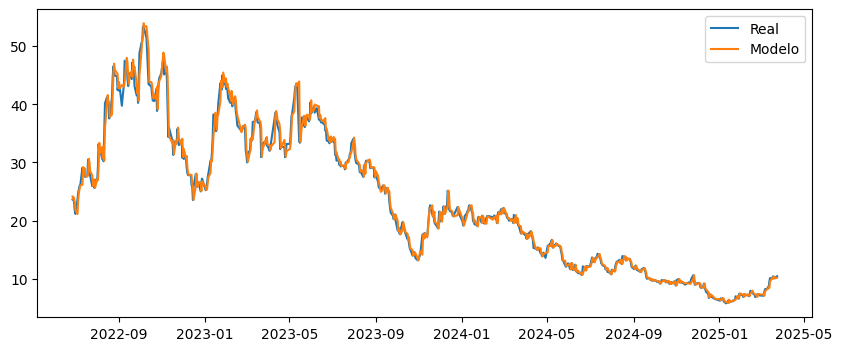

In [99]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(datas.iloc[tamanho_dados_treinamento:], precos_teste_reais[:, 1], label='Real')
ax.plot(datas.iloc[tamanho_dados_treinamento:], precos_teste_preditos[:, 1], label='Modelo')

plt.legend()
plt.show()

Expectativa Matemática: 0.1229%


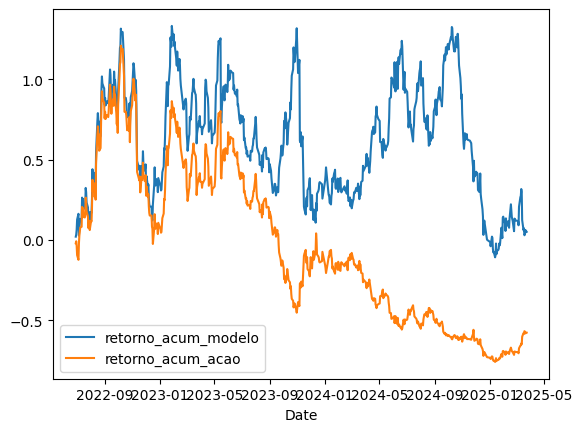

,retorno_acum_modelo,retorno_acum_acao
Date,,
2022-06-28,0.020576,-0.020576
2022-06-29,0.033441,-0.008230
2022-06-30,0.063457,-0.037037
2022-07-01,0.127083,-0.094650
2022-07-04,0.162945,-0.123457
...,...,...
2025-03-18,0.072054,-0.584649
2025-03-19,0.0293,-0.568085
2025-03-20,0.035221,-0.570570


In [100]:
df = pd.DataFrame(precos_teste_preditos, index=datas.iloc[tamanho_dados_treinamento:])
df.columns = ['preco', 'preco_predito_dia_seguinte']
df['retorno'] = df['preco'].pct_change()
df['comprado_vendido'] = pd.NA

df.loc[df['preco_predito_dia_seguinte'] > df['preco'], 'comprado_vendido'] = 'comprado'
df.loc[df['preco_predito_dia_seguinte'] < df['preco'], 'comprado_vendido'] = 'vendido'

df['acertos'] = pd.NA
df.loc[(df['comprado_vendido'] == 'comprado') & (df['retorno'] > 0), 'acertos'] = 1
df.loc[(df['comprado_vendido'] == 'comprado') & (df['retorno'] < 0), 'acertos'] = 0
df.loc[(df['comprado_vendido'] == 'vendido') & (df['retorno'] > 0), 'acertos'] = 0
df.loc[(df['comprado_vendido'] == 'vendido') & (df['retorno'] < 0), 'acertos'] = 1
df.loc[df['acertos'].isna(), 'acertos'] = 0

df = df.dropna()

acertou_o_lado = df['acertos'].sum() / len(df)
errou_o_lado = 1 - acertou_o_lado

df['retorno_absoluto'] = df['retorno'].abs()
media_lucros_e_perdas = df.groupby('acertos')['retorno_absoluto'].mean()

exp_mat_lucro = acertou_o_lado * media_lucros_e_perdas[1] - media_lucros_e_perdas[0] * errou_o_lado

print(f"Expectativa Matemática: {exp_mat_lucro * 100:.4f}%")

df['retorno_modelo'] = pd.NA
df.loc[df['acertos'] == True, 'retorno_modelo'] = df.loc[df['acertos'] == True]['retorno_absoluto']
df.loc[df['acertos'] == False, 'retorno_modelo'] = df.loc[df['acertos'] == False]['retorno_absoluto'] * -1

df['retorno_acum_modelo'] = (1 + df['retorno_modelo']).cumprod() - 1
df['retorno_acum_acao'] = (1 + df['retorno']).cumprod() - 1

retornos = df[['retorno_acum_modelo', 'retorno_acum_acao']]
retornos.plot()
plt.show()
display(retornos)